# Project 02: Classification - Titanic ML Challange 

## 1. Defining project Goal 

Creating ML model that classifies Titanic passengers survived or deceased with 80% accuracy.

## 2. Importing Libraries

In [271]:
# for EDA 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# for Training model:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

# for Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# for Evaluating Classifiers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

## 3. Getting Data

In [66]:
# Loading training and test datasets 
df = pd.read_csv('data/train.csv', index_col=0)

In [67]:
# Dimensions of the datasets
df.shape

(891, 11)

## 4. Exploratory Data Analysis (EDA)

In [68]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 4.1 Missing Data

<AxesSubplot:ylabel='PassengerId'>

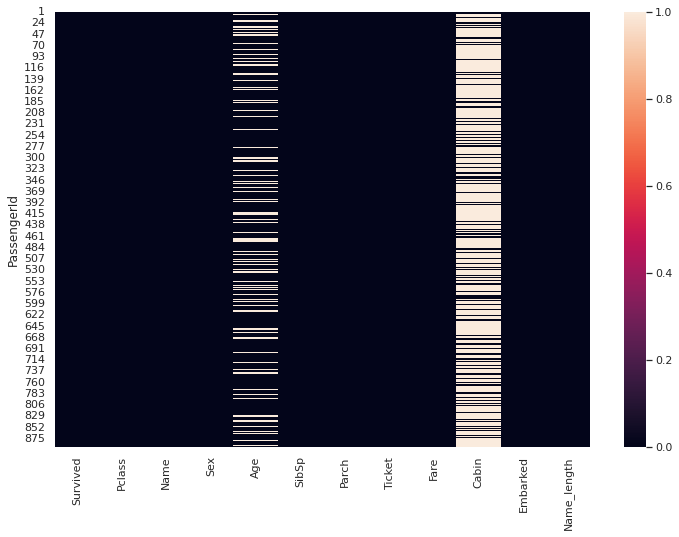

In [136]:
# Creating heatmap to see in which features can be found missing data. 
plt.figure(figsize=(12,8)) 
sns.heatmap(df.isnull())


<AxesSubplot:ylabel='PassengerId'>

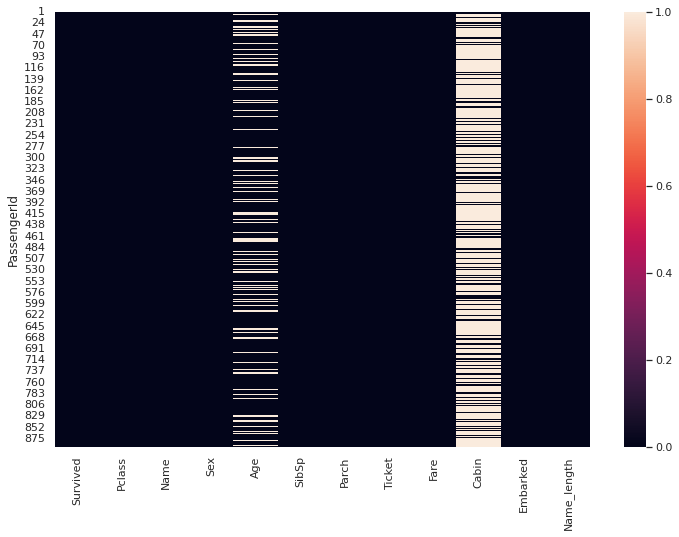

In [137]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.isnull())
# alt: sns.heatmap(df.isna())

In [71]:
# is there any missing data in [Age]
df[['Age']].isnull().values.any()

True

In [72]:
# the number of missing data in [Age]
df['Age'].isnull().sum()

177

In [73]:
# the number of missing data in [Cabin]
df['Cabin'].isnull().sum()

687

177/891 observation is NaN in [Age] and 687/891 in [Cabin], therefore I decided not to use this [Cabin] in the model. The missing values of [Age] I will substitute with the Mean value in the step of Feature Engineering with SimpleImputer(). 

The following categorical features do not seem to contribute [Ticket, Embarked] to the accuracy of the prediction, therefore I will remove them from the model. 

### 4.2. Transforming ['Name'] 

In [74]:
# length of passenger names was converted into numbers (maybe aristocrats with titles and longer names had a better chance to survive): 
def name_length(df):
    length = df[df.columns[2]].str.len()
    return length.values.reshape(-1, 1)

In [75]:
df['Name_length'] = name_length(df)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24


### 4.3. Checking correlations and plotting

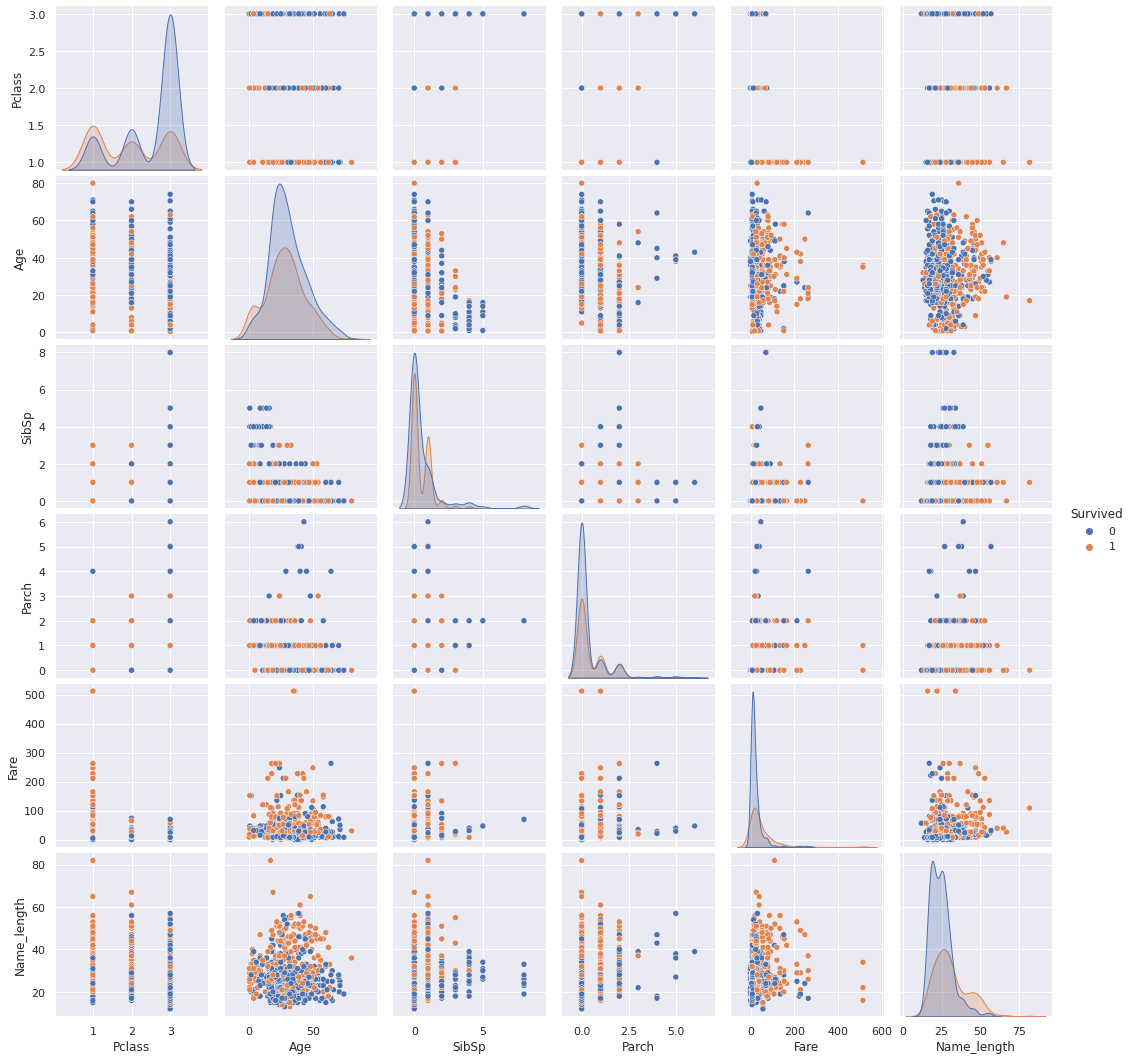

In [78]:
# shape of data
sns.pairplot(df, hue='Survived')

In [79]:
# Correlation between Survived and numerical features 
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Name_length
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.332350
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.220001
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.034612
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.165019
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.252282
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.155832
Name_length,0.332350,-0.220001,0.034612,0.165019,0.252282,0.155832,1.000000


<AxesSubplot:>

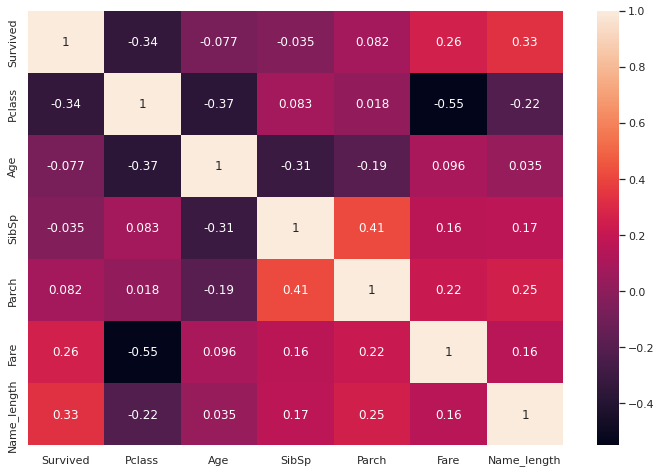

In [80]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(),annot=True)

<AxesSubplot:>

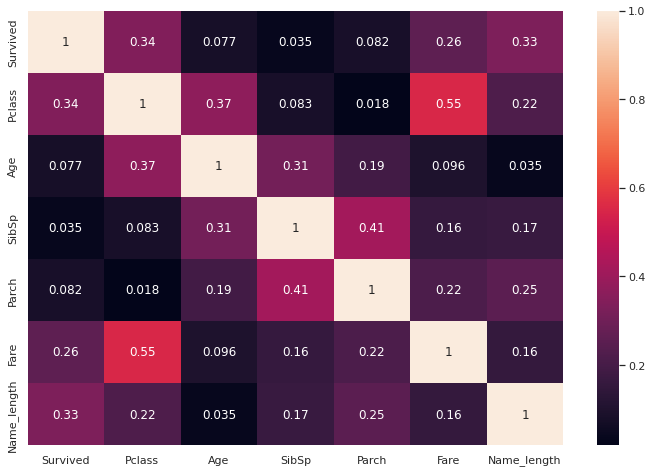

In [81]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr().abs(), annot=True)

The following numerical features show the strongest correlation with [Survived]: 

Pclass: -0.34 	

Fare: 0.26

Name_length: 0.33

<AxesSubplot:title={'center':'[Sex] and [Survived]'}, xlabel='Sex', ylabel='count'>

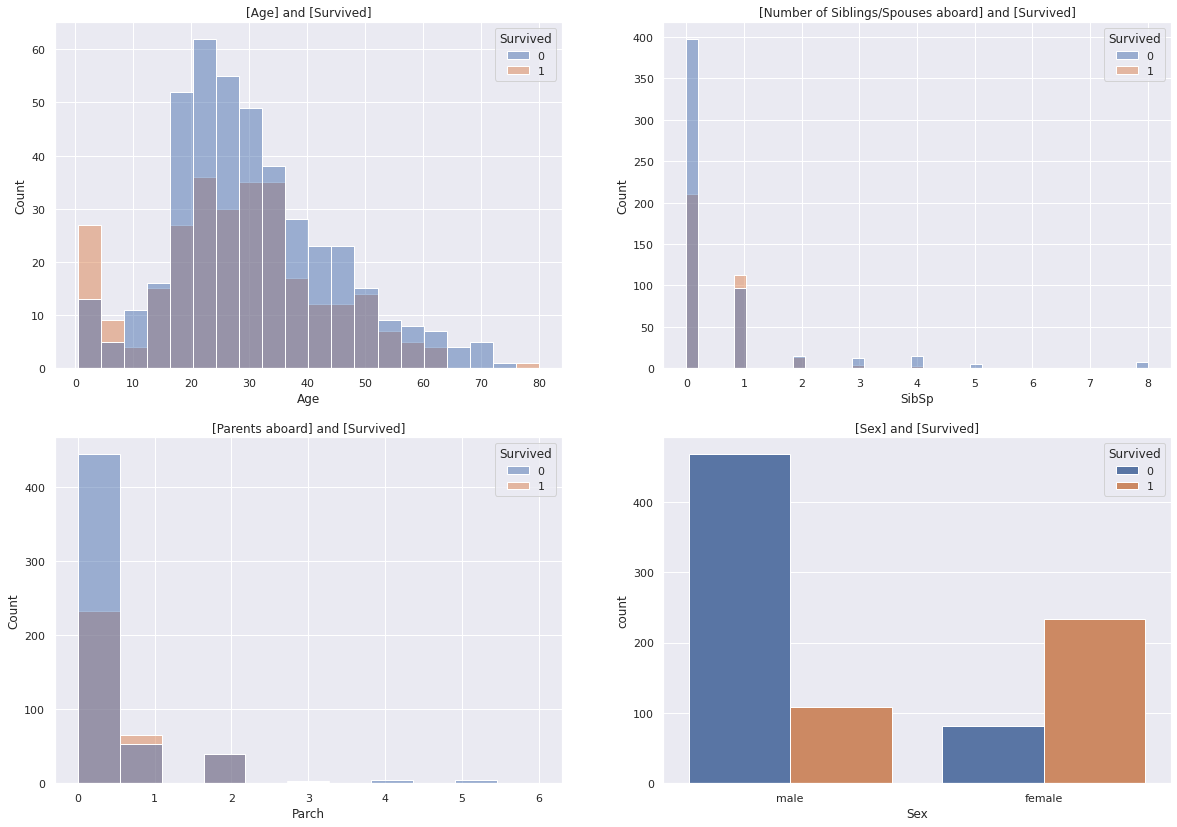

In [139]:
fig = plt.figure(figsize=(20,14))

#  subplot #1
plt.subplot(221)
plt.title('[Age] and [Survived]')
sns.histplot(x='Age', hue='Survived', data=df)

#  subplot #2
plt.subplot(222)
plt.title('[Number of Siblings/Spouses aboard] and [Survived]')
sns.histplot(x='SibSp', hue='Survived', data=df) 

#  subplot #3
plt.subplot(223)
plt.title('[Parents aboard] and [Survived]')
sns.histplot(x='Parch', hue='Survived', data=df) 

#  subplot #4
plt.subplot(224)
plt.title('[Sex] and [Survived]')
sns.countplot(x='Sex', hue='Survived', data=df)

The age distribution shows Passenger under 10 had and over 80 higher probability to survive, between 10-25 and 35-50 much higher probability to decease.

According to the barchart there is a correlation between Sex and Survived. Much more male died and much more female survived.

### 4.4 Assigning X and y for training

In [86]:
# Keeping the following features in training dataset: Sex, Pclass, Age, SibSp, Fare and Name_lenght. 
# Dropping the rest of the columns.    
X = df.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Parch'], axis=1)
y = df['Survived']

### 4.5  Train-test split X and y data

In [87]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [88]:
Xtrain 

,Pclass,Sex,Age,SibSp,Fare,Name_length
PassengerId,,,,,,
412,3,male,NaN,0,6.8583,15
551,1,male,17.0,0,110.8833,27
550,2,male,8.0,1,36.7500,30
71,2,male,32.0,0,10.5000,26
464,2,male,48.0,0,13.0000,28
...,...,...,...,...,...,...
883,3,female,22.0,0,10.5167,28
655,3,female,18.0,0,6.7500,28
217,3,female,27.0,0,7.9250,22


In [89]:
ytrain

PassengerId
412    0
551    1
550    1
71     0
464    0
      ..
883    0
655    0
217    1
469    0
193    1
Name: Survived, Length: 668, dtype: int64

## 5. Feature Engineering

Steps according to Features: 
    
    Pclass: one hot encoding (converting categorical variables into binary features)
    Sex: one hot encoding 
    Age: Imputation (filling missing values) + scaling (normalize the data to the range 0.0 - 1.0)
    SibSp: one hot encoding   
    Fare: Imputation + scaling
    Name_length: scaling
        
Steps according to FE techniques:  

    Imputer: filling missing values in [Age] and [Fare] with mean
    OneHotEncoder: converting categorical variables into numbers in [Pclass], [Sex], [SibSp]
    MinMaxScaler: scale numerical colums in [Age], [Name_length] and [Fare]
    
Since [Age] and [Fare] needs imputation and scaling, I apply pipeline for combining the 2 techniques.  


In [90]:
impute_scale_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
]) 

In [91]:
column_transformer = ColumnTransformer([
    ('impute_scale_pipeline', impute_scale_pipeline, ['Age', 'Fare']),
    ('cat_ohe', OneHotEncoder(), ['Pclass', 'Sex', 'SibSp']),
    ('num_scaler', MinMaxScaler(), ['Name_length'])
])

In [92]:
Xtrain.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Name_length'], dtype='object')

In [105]:
column_transformer.fit(Xtrain)
Xtrain_fe = column_transformer.transform(Xtrain)
Xtest_fe = column_transformer.transform(Xtest)

In [106]:
# checking whether the FE applied in the train and test dataset
Xtrain.shape, Xtrain_fe.shape, ytrain.shape

((668, 6), (668, 15), (668,))

In [107]:
Xtest.shape, Xtest_fe.shape, ytest.shape

((223, 6), (223, 15), (223,))

In [110]:
pd.DataFrame(Xtrain_fe)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.372112,0.013387,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042857
1,0.208344,0.216430,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286
2,0.095250,0.071731,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.257143
3,0.396833,0.020495,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000
4,0.597889,0.025374,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.228571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.271174,0.020527,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.228571
664,0.220910,0.013175,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.228571
665,0.334004,0.015469,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857
666,0.372112,0.015078,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714


## 6. Logistic Regression model

### 6.1. Fit LogReg model on traning data, checking accuracy score

In [336]:
# train the model using Logistic regression 

LogReg = LogisticRegression()
LogReg.fit(Xtrain_fe, ytrain)  

LogisticRegression()

In [337]:
# Evaluating the model 
train_score = LogReg.score(Xtrain_fe, ytrain)
train_score

0.811377245508982

In [338]:
# print training and test scores
f' Train scores:  {round(LogReg.score(Xtrain_fe, ytrain),3)},  Test scores {round(LogReg.score(Xtest_fe,ytest),3)}'

' Train scores:  0.811,  Test scores 0.78'

### 6.2. Cross validation

In [339]:
cv_accuracy = cross_val_score(LogReg, Xtrain_fe, ytrain, cv=10, scoring='accuracy')
cv_accuracy

array([0.8358209 , 0.85074627, 0.79104478, 0.80597015, 0.74626866,
       0.86567164, 0.86567164, 0.76119403, 0.78787879, 0.81818182])

In [340]:
f"Cross-validation: accuracy mean {100 * cv_accuracy.mean():5.2f} +- {100 * cv_accuracy.std():5.2f} %"

'Cross-validation: accuracy mean 81.28 +-  3.98 %'

In [341]:
cv = cross_validate(LogReg, Xtrain_fe, ytrain,
                    cv=10,
                    scoring='accuracy',
                    return_train_score=True)
cv = pd.DataFrame(cv)
print(cv)

   fit_time  score_time  test_score  train_score
0  0.020690    0.000582    0.835821     0.810316
1  0.017743    0.000945    0.850746     0.810316
2  0.019854    0.000570    0.791045     0.813644
3  0.020372    0.000681    0.805970     0.811980
4  0.019512    0.000587    0.746269     0.818636
5  0.017350    0.000643    0.865672     0.805324
6  0.025805    0.000853    0.865672     0.805324
7  0.019593    0.000592    0.761194     0.815308
8  0.026040    0.000635    0.787879     0.815615
9  0.049885    0.000575    0.818182     0.812292


<BarContainer object of 10 artists>

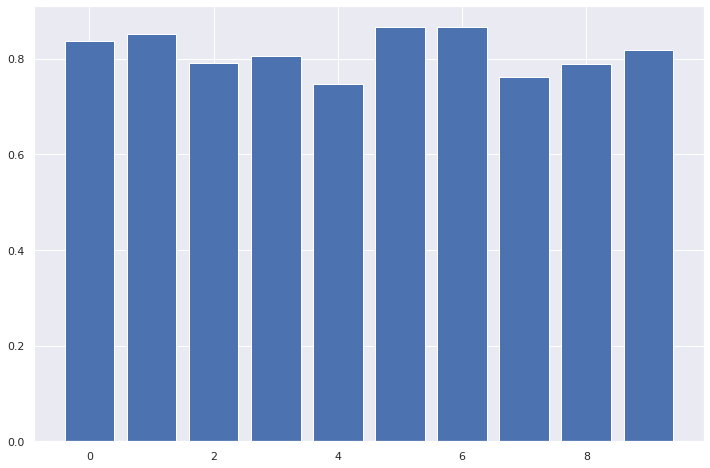

In [342]:
# visualising the distribution of the results
plt.figure(figsize=(12, 8))
plt.bar(range(10), cv_accuracy)

In [343]:
# checking if the score inside the range of the cross validation scores?
train_score > cv_accuracy.min() and train_score < cv_accuracy.max()

True

### 6.3. GridsearchCV - Hyperparameter optimization 

In [352]:
param_grid = {
    'solver' : ['newton-cg', 'liblinear'],
    'max_iter': [50, 100, 150, 200],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}
param_grid

{'solver': ['newton-cg', 'liblinear'],
 'max_iter': [50, 100, 150, 200],
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [353]:
gscv = GridSearchCV(LogReg, param_grid, 
                  return_train_score=False, 
                  scoring='accuracy', 
                  cv=10)

In [354]:
import warnings
warnings.filterwarnings('ignore')

results = gscv.fit(Xtrain_fe, ytrain)

In [355]:
# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 0.8188602442333786
Best Hyperparameters: {'C': 1e-05, 'max_iter': 50, 'penalty': 'none', 'solver': 'newton-cg'}


### 6.4. Evaluation performance of LogReg model

In [175]:
# Predicting y value (Survived) of the test dataset 
ypred = LogReg.predict(Xtest_fe)
ypred

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0])

In [176]:
# the calculated probabilities of the 2 values of the target variable (Survived or deceased) of test dataset
# indicates the likeliness of an observation to belong to each class

LogReg.predict_proba(Xtest_fe)

array([[0.75260352, 0.24739648],
       [0.10637825, 0.89362175],
       [0.33219191, 0.66780809],
       [0.91619537, 0.08380463],
       [0.09808742, 0.90191258],
       [0.797681  , 0.202319  ],
       [0.89689117, 0.10310883],
       [0.45189154, 0.54810846],
       [0.88155416, 0.11844584],
       [0.7712388 , 0.2287612 ],
       [0.59898292, 0.40101708],
       [0.45807693, 0.54192307],
       [0.90923428, 0.09076572],
       [0.04659632, 0.95340368],
       [0.58886436, 0.41113564],
       [0.3532062 , 0.6467938 ],
       [0.89873176, 0.10126824],
       [0.44300253, 0.55699747],
       [0.88975219, 0.11024781],
       [0.92565642, 0.07434358],
       [0.11360221, 0.88639779],
       [0.53393224, 0.46606776],
       [0.08118463, 0.91881537],
       [0.5917264 , 0.4082736 ],
       [0.4622987 , 0.5377013 ],
       [0.85947389, 0.14052611],
       [0.50323975, 0.49676025],
       [0.87593144, 0.12406856],
       [0.69724345, 0.30275655],
       [0.88573992, 0.11426008],
       [0.

In [183]:
# same as accuracy
test_score = LogReg.score(Xtest_fe, ytest)
test_score

0.7802690582959642

In [195]:
# checking if the test score inside the range of the cross validation scores?
test_score > cv_accuracy.min() and train_score < cv_accuracy.max()

True

In [179]:
#normalising confusion matrix for easier interpretation
norm_cm = (confusion_matrix(ytest, ypred) / confusion_matrix(ytest, ypred).sum()) * 100
norm_cm = norm_cm.round(2)

<AxesSubplot:>

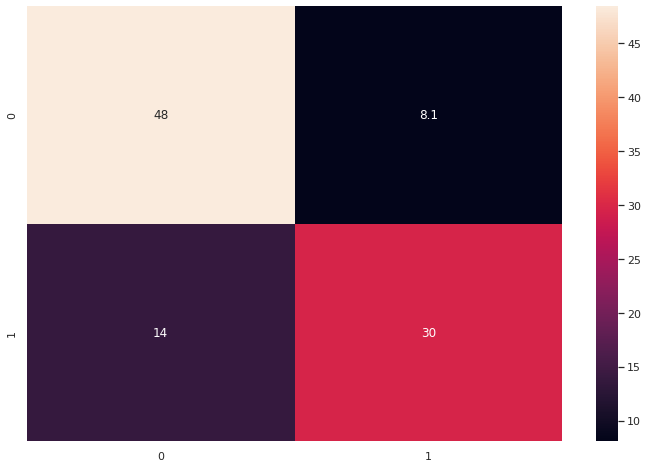

In [180]:
# Confusion matrix
plt.figure(figsize=(12,8))
sns.heatmap(norm_cm, annot=True)

Evaluation of the Confusion Matrix: 

8,1 % of the predictions are False Positive.<br> 
14 % of the predictions are False Negative.<br> 
48 % of the predictions are True Negative.<br> 
30 % of the predictions are True Positive.<br> 

In [196]:
# Accuracy: The percentage of correct guesses. 78 % of the predictions are correct.
accuracy_score(ytest, ypred)

0.7802690582959642

In [197]:
# Precision: The ratio of the True positives from all positively classified. tp / tp + fp
precision_score(ytest, ypred)

0.7857142857142857

In [198]:
# Recall: The ratio of positive observations correctly classified as positive. tp / tp + fn
recall_score(ytest, ypred)

0.6804123711340206

In [199]:
# F1-score: Harmonic mean of precision and recall
f1_score(ytest, ypred)

0.729281767955801

Text(0.5, 1.0, 'roc curve')

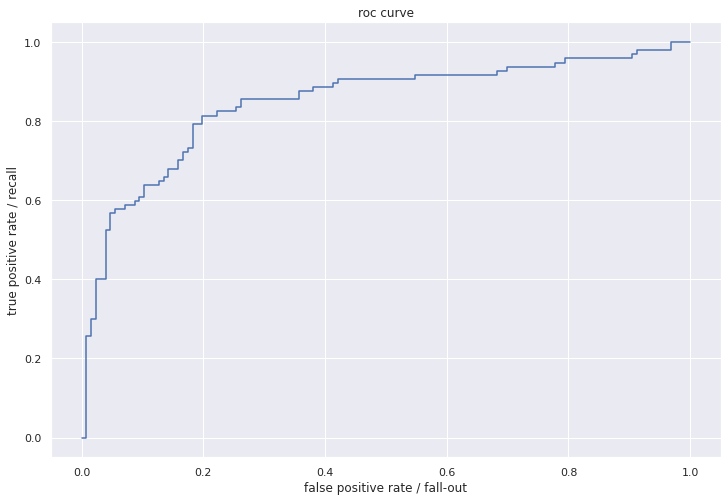

In [201]:
# roc curve
ypred_proba = LogReg.predict_proba(Xtest_fe)[:,1]
fpr, tpr, threshold = roc_curve(ytest, ypred_proba)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.xlabel('false positive rate / fall-out')
plt.ylabel('true positive rate / recall')
plt.title('roc curve')

In [215]:
# the performance of LogReg by measuring the area under the curve:
auc(fpr, tpr)

0.8470790378006873

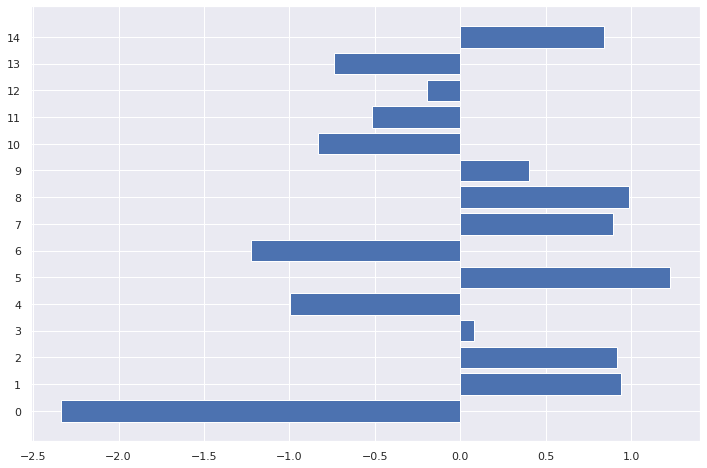

In [239]:
# Examining the strength of the coefficients for each feature
plt.figure(figsize=(12,8))
plt.barh(range(15), LogReg.coef_[0])
plt.yticks(range(15), pd.DataFrame(Xtrain_fe).columns)
None

## 7. RandomForest model 

### 7.1. Fit RanFor model on traning data, checking accuracy score

In [263]:
# train the model using RandomForestClasifier 
RanFor = RandomForestClassifier()
RanFor.fit(Xtrain_fe, ytrain)  

RandomForestClassifier()

In [264]:
# Evaluating the model 
train_score = RanFor.score(Xtrain_fe, ytrain)
train_score

0.9970059880239521

In [265]:
# print training and test scores
f' Train scores:  {round(RanFor.score(Xtrain_fe, ytrain),3)}, Test scores {round(RanFor.score(Xtest_fe, ytest),3)}'

' Train scores:  0.997, Test scores 0.771'

### 7.2. Cross Validation

In [266]:
cv_accuracy = cross_val_score(RanFor, Xtrain_fe, ytrain, cv=10, scoring='accuracy')
cv_accuracy

array([0.80597015, 0.86567164, 0.7761194 , 0.76119403, 0.80597015,
       0.82089552, 0.8358209 , 0.7761194 , 0.75757576, 0.78787879])

In [267]:
f"Cross-validation: accuracy mean {100 * cv_accuracy.mean():5.2f} +- {100 * cv_accuracy.std():5.2f} %"

'Cross-validation: accuracy mean 79.93 +-  3.27 %'

Since the model with RandomForestClassifier has worse accuracy score than LogisticRegression, I decided to use the latter one for prediction. 

### 7.3. Feature Importance with RandomForest

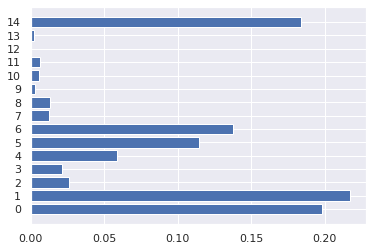

In [269]:
plt.barh(range(15), RanFor.feature_importances_)
plt.yticks(range(15),  pd.DataFrame(Xtrain_fe).columns)
None

## 8. Prediction

### 8.1. Transforming kaggle test data in the same way as the training data

In [380]:
# loading test dataset of Kaggle 
df_submit = pd.read_csv('data/test.csv', index_col=0)
df_submit

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [381]:
# Creating Name_lenght column with name_lenght function in test dataset as well
def name_length(df):
    length = df[df.columns[1]].str.len()
    return length.values.reshape(-1, 1)

In [382]:
df_submit['Name_length'] = name_length(df_submit)

In [383]:
# dropping columns
# Keeping the following features in test dataset: Sex, Pclass, Age, SibSp, Fare and Name_lenght. 
df_submit.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Parch'], axis=1, inplace=True)

In [384]:
df_submit

,Pclass,Sex,Age,SibSp,Fare,Name_length
PassengerId,,,,,,
892,3,male,34.5,0,7.8292,16
893,3,female,47.0,1,7.0000,32
894,2,male,62.0,0,9.6875,25
895,3,male,27.0,0,8.6625,16
896,3,female,22.0,1,12.2875,44
...,...,...,...,...,...,...
1305,3,male,NaN,0,8.0500,18
1306,1,female,39.0,0,108.9000,28
1307,3,male,38.5,0,7.2500,28


In [385]:
# feature engineering
Xsubmit_fe = column_transformer.transform(df_submit)
Xsubmit_fe.shape

(418, 15)

### 8.2. Predictions with final model 

In [401]:
# train the model using LogisticRegression with the best parameters of the Gridsearch
LogReg = LogisticRegression(penalty='none', max_iter=50, solver='newton-cg', C=1e-05)
LogReg.fit(Xtrain_fe, ytrain)  

LogisticRegression(C=1e-05, max_iter=50, penalty='none', solver='newton-cg')

In [402]:
# predictions with Logistic Regression 
ysubmit = LogReg.predict(Xsubmit_fe)

In [403]:
ysubmit

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [404]:
predictions = pd.DataFrame({'PassengerId': df_submit.index, 'Survived': ysubmit})
predictions.to_csv('predictions_submit.csv', index=False) 

In [405]:
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
